<a href="https://colab.research.google.com/github/XavierRG0417/Econometria-com-Python/blob/main/curva_de_phillips_regressao_quantilica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Curva de Phillips utilizando Regressão Quantílica e OLS

Este script realiza uma análise da Curva de Phillips, explorando a relação entre a taxa de desemprego e a inflação (CPI), utilizando **Regressão Quantílica**. A automação dos dados econômicos é feita diretamente pela API do **FRED (Federal Reserve Economic Data)**, permitindo o acesso contínuo aos dados mais recentes. A Regressão Quantílica é uma técnica estatística que permite estimar diferentes quantis de uma variável dependente em função de uma ou mais variáveis independentes, fornecendo uma visão mais detalhada do que uma simples regressão linear.

### Objetivo:
O objetivo é analisar como a relação entre o desemprego e a inflação varia ao longo da distribuição condicional da inflação, capturando insights que um modelo de **Mínimos Quadrados Ordinários (OLS)** não pode oferecer. Além disso, o script também gera os resultados da regressão OLS para comparação.

### Funcionalidades:
- **Automação de dados macroeconômicos via API do FRED**: Este script acessa automaticamente dados como a **Inflação (CPI)** e a **Taxa de Desemprego (UNRATE)**, utilizando a API do FRED para garantir que os dados sejam sempre atualizados.
- **Estima a Curva de Phillips com Regressão Quantílica**: Os modelos são estimados para quantis de 0.05 a 0.95, oferecendo uma visão granular da relação entre as variáveis.
- **Comparação com Regressão OLS**: Além da Regressão Quantílica, também é estimado um modelo de Regressão Linear Simples (OLS), fornecendo uma linha de base para comparação dos resultados.
- **Visualizações Gráficas**: Gera gráficos detalhados que incluem as estimativas dos coeficientes para diferentes quantis, junto com os intervalos de confiança e os resultados do OLS.

### Dados Utilizados:
- **Inflação**: **CPI (Consumer Price Index)**.
- **Taxa de Desemprego**: **UNRATE** (Unemployment Rate).

### Pré-requisitos:
- Python 3.x
- Bibliotecas necessárias: `numpy`, `pandas`, `statsmodels`, `matplotlib`, `pandas_datareader`
- **Chave da API do FRED**: Para acessar os dados diretamente da fonte, será necessário gerar uma chave de API no site do FRED.

### Como Funciona:
1. O script utiliza a **API do FRED** para importar automaticamente os dados econômicos.
2. Em seguida, os dados são processados para calcular os retornos e preparar a base para as regressões.
3. A **Regressão Quantílica** é realizada para uma faixa de quantis (0.05 a 0.95), permitindo explorar como o impacto da taxa de desemprego sobre a inflação varia em diferentes partes da distribuição da inflação.
4. Os resultados são comparados com a Regressão Linear Simples (**OLS**), que estima o impacto médio.
5. Os gráficos finais permitem visualizar tanto os coeficientes estimados quanto as distribuições de erros para cada quantil e para o modelo OLS.

Este script é uma poderosa ferramenta para quem deseja entender a relação entre desemprego e inflação de forma mais detalhada, utilizando uma abordagem robusta e moderna como a **Regressão Quantílica**, além de fornecer uma automação completa para acesso contínuo aos dados econômicos do **FRED**.

Este código pode ser adaptado para outros cenários econômicos ao acessar diferentes séries temporais do FRED ou ajustando a fórmula da regressão.



In [1]:
  # Importando bibliotecas para o script
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import yfinance as yf
import pandas_datareader
import pandas_datareader.data as web
from scipy.stats import norm

In [ ]:
# Definindo o período de análise
start_date = '2000-01-01'
end_date = '2024-09-10'

# Lista de variáveis macroeconômicas do FRED
macro_vars_fred = {
    'UNRATE': 'Unemployment Rate',
    'CPIAUCSL': 'CPI'
}

# Função para obter dados macroeconômicos do FRED
def get_macro_data(macro_vars_fred, api_key):
    macro_data = {}
    for fred_code, var_name in macro_vars_fred.items():
        try:
            data = web.DataReader(fred_code, 'fred', start_date, end_date, api_key=api_key)
            macro_data[var_name] = data
        except Exception as e:
            print(f"Error fetching {fred_code}: {e}")
    return pd.concat(macro_data.values(), axis=1, keys=macro_data.keys())

# Sua chave de API do FRED
api_key = 'xxxxxx'

# Coletando dados macroeconômicos do FRED
macro_data = get_macro_data(macro_vars_fred, api_key)

# Preencher valores nulos com o último valor disponível
macro_data_filled = macro_data.fillna(method='ffill')

# Remover quaisquer linhas restantes que contenham NaN
macro_data_filled.dropna(how='any', inplace=True)

# Verificar se ainda existem valores nulos e informações do dataframe
print(macro_data_filled.isnull().sum())
macro_data_filled.info()

Unemployment Rate  UNRATE      0
CPI                CPIAUCSL    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 296 entries, 2000-01-01 to 2024-08-01
Freq: MS
Data columns (total 2 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   (Unemployment Rate, UNRATE)  296 non-null    float64
 1   (CPI, CPIAUCSL)              296 non-null    float64
dtypes: float64(2)
memory usage: 6.9 KB


C:\Users\xavie\AppData\Local\Temp\ipykernel_29236\1265919237.py:29: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  macro_data_filled = macro_data.fillna(method='ffill')


In [ ]:
macro_data_filled

,Unemployment Rate,CPI
,UNRATE,CPIAUCSL
DATE,,
2000-01-01,4.0,169.300
2000-02-01,4.1,170.000
2000-03-01,4.0,171.000
2000-04-01,3.8,170.900
2000-05-01,4.0,171.200
...,...,...
2024-04-01,3.9,313.207
2024-05-01,4.0,313.225


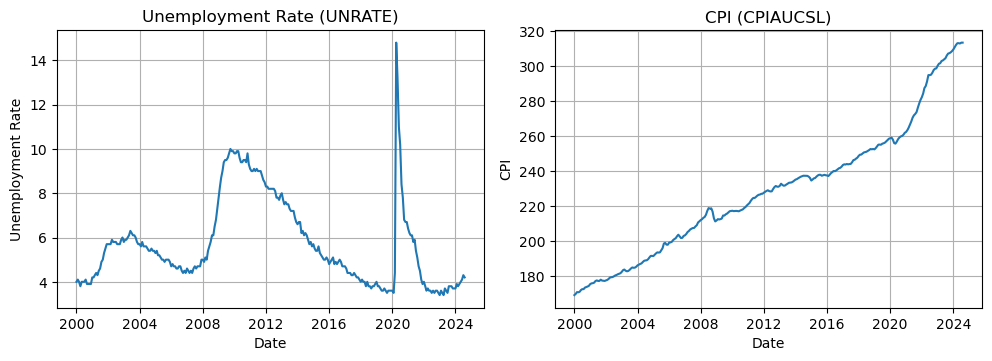

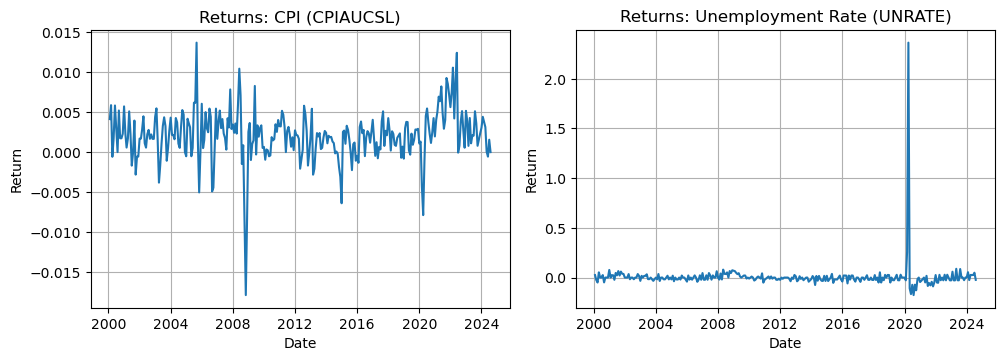

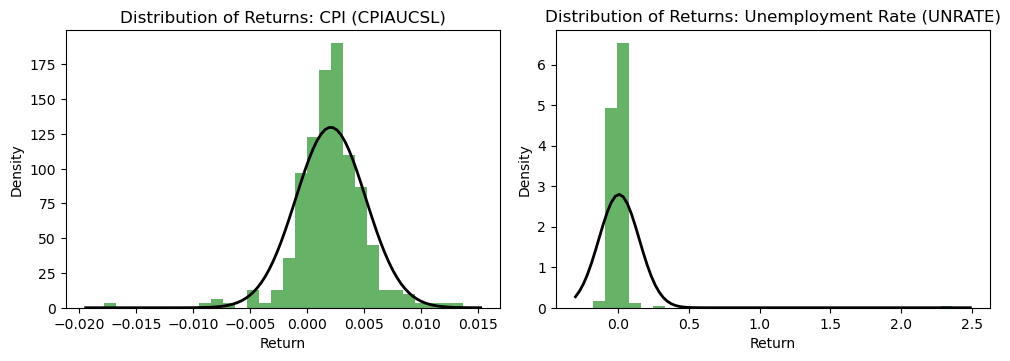

In [ ]:
# Calculando os retornos Logarithmicos
log_return_vars = [('CPI', 'CPIAUCSL')]

log_returns = np.log(macro_data_filled[log_return_vars] / macro_data_filled[log_return_vars].shift(1))

# Calculando os retornos simples para o desemprego
pct_change_vars = [('Unemployment Rate', 'UNRATE')]

pct_changes = macro_data_filled[pct_change_vars].pct_change()

# Combinar as daus variáveis em um únido dataframe novamente
combined_returns = pd.concat([log_returns, pct_changes], axis=1).dropna()

# Plotando a série histórica das variáveis
plt.figure(figsize=(15, 10))
for i, column in enumerate(macro_data_filled.columns, 1):
    plt.subplot(3, 3, i)
    plt.plot(macro_data_filled.index, macro_data_filled[column])
    plt.title(f'{column[0]} ({column[1]})')
    plt.xlabel('Date')
    plt.ylabel(column[0])
    plt.grid(True)
plt.tight_layout()
plt.show()

# Plotando a série histórica dos retornos
plt.figure(figsize=(15, 10))
for i, column in enumerate(combined_returns.columns, 1):
    plt.subplot(3, 3, i)
    plt.plot(combined_returns.index, combined_returns[column])
    plt.title(f'Returns: {column[0]} ({column[1]})')
    plt.xlabel('Date')
    plt.ylabel('Return')
    plt.grid(True)
plt.tight_layout()
plt.show()

# Plotando a distribuição dos retornos com a curva normal
plt.figure(figsize=(15, 10))
for i, column in enumerate(combined_returns.columns, 1):
    plt.subplot(3, 3, i)
    data = combined_returns[column].dropna()
    plt.hist(data, bins=30, density=True, alpha=0.6, color='g')

    # Fit distribuição normal
    mu, std = norm.fit(data)
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'k', linewidth=2)

    plt.title(f'Distribution of Returns: {column[0]} ({column[1]})')
    plt.xlabel('Return')
    plt.ylabel('Density')
plt.tight_layout()
plt.show()

In [ ]:
# Renomear as colunas do DataFrame `combined_returns`
combined_returns.columns = ['CPI_CPIAUCSL','UNRATE']

# Exibir as primeiras linhas para verificar a mudança
print(combined_returns.head())

            CPI_CPIAUCSL    UNRATE
DATE                              
2000-02-01      0.004126  0.025000
2000-03-01      0.005865 -0.024390
2000-04-01     -0.000585 -0.050000
2000-05-01      0.001754  0.052632
2000-06-01      0.005824  0.000000


In [ ]:
# Certificar que o índice está no formato datetime
combined_returns.index = pd.to_datetime(combined_returns.index)

# Verificar os dados de abril de 2020 antes da remoção
print(combined_returns.loc['2020-04'])

# Remover todas as linhas referentes ao mês de abril de 2020
combined_cleaned = combined_returns.loc[~combined_returns.index.to_period('M').isin([pd.Period('2020-04')])]

# Verificar se as linhas de abril de 2020 foram removidas corretamente
print(combined_cleaned.loc['2020-04':'2020-05'])
# Renomear o dataframe novamente
combined_returns = combined_cleaned

            CPI_CPIAUCSL    UNRATE
DATE                              
2020-04-01     -0.007871  2.363636
            CPI_CPIAUCSL    UNRATE
DATE                              
2020-05-01     -0.001086 -0.108108


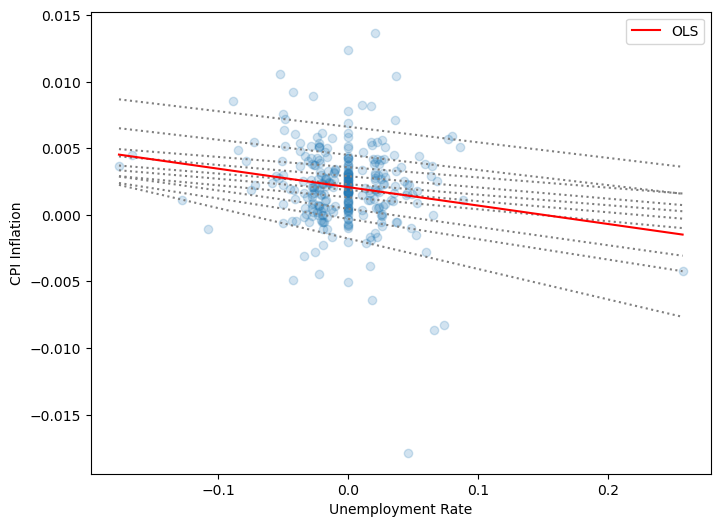

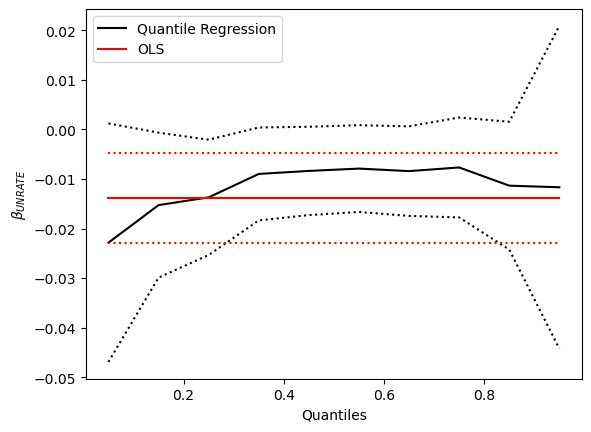

Resultados da Regressão Quantílica:
      q  Intercept    UNRATE        lb        ub
0  0.05  -0.001785 -0.022858 -0.046905  0.001188
1  0.15  -0.000306 -0.015284 -0.029903 -0.000666
2  0.25   0.000456 -0.013719 -0.025346 -0.002092
3  0.35   0.001316 -0.008997 -0.018364  0.000371
4  0.45   0.001867 -0.008387 -0.017291  0.000517
5  0.55   0.002304 -0.007916 -0.016671  0.000838
6  0.65   0.002899 -0.008428 -0.017458  0.000603
7  0.75   0.003577 -0.007690 -0.017760  0.002380
8  0.85   0.004500 -0.011359 -0.024247  0.001528
9  0.95   0.006610 -0.011687 -0.044227  0.020853

Resultados da Regressão OLS:
Intercept: 0.0020779066983615435
Coeficiente UNRATE: -0.01384885055273344
Intervalo de Confiança (95%) do Coeficiente UNRATE: -0.02294584647383155 - -0.004751854631635331


In [ ]:
# Definir a fórmula de regressão quantílica usando os nomes das colunas corretos
mod = smf.quantreg("CPI_CPIAUCSL ~ UNRATE", combined_returns)

# Definir os quantis para a regressão
quantiles = np.arange(0.05, 0.96, 0.1)

# Ajustar o modelo de regressão quantílica para cada quantil
def fit_model(q):
    res = mod.fit(q=q)
    return [q, res.params["Intercept"], res.params["UNRATE"]] + res.conf_int().loc["UNRATE"].tolist()

# Estimar os coeficientes para cada quantil
models = [fit_model(x) for x in quantiles]
models = pd.DataFrame(models, columns=["q", "Intercept", "UNRATE", "lb", "ub"])

# Ajustar um modelo OLS para comparação
ols = smf.ols("CPI_CPIAUCSL ~ UNRATE", combined_returns).fit()
ols_ci = ols.conf_int().loc["UNRATE"].tolist()
ols = dict(Intercept=ols.params["Intercept"], UNRATE=ols.params["UNRATE"], lb=ols_ci[0], ub=ols_ci[1])

# Plotar os resultados das regressões
x = np.linspace(combined_returns['UNRATE'].min(), combined_returns['UNRATE'].max(), 100)
get_y = lambda a, b: a + b * x

# Plotando quantis
fig, ax = plt.subplots(figsize=(8, 6))

for i in range(models.shape[0]):
    y_fit = get_y(models.Intercept[i], models.UNRATE[i])
    ax.plot(x, y_fit, linestyle="dotted", color="grey")

# OLS
y_ols = get_y(ols["Intercept"], ols["UNRATE"])
ax.plot(x, y_ols, color="red", label="OLS")
ax.scatter(combined_returns['UNRATE'], combined_returns['CPI_CPIAUCSL'], alpha=0.2)
ax.set_xlabel("Unemployment Rate")
ax.set_ylabel("CPI Inflation")
plt.legend()
plt.show()

# Plot das estimativas de UNRATE por quantis
n = models.shape[0]
plt.plot(models.q, models.UNRATE, color="black", label="Quantile Regression")
plt.plot(models.q, models.ub, linestyle="dotted", color="black")
plt.plot(models.q, models.lb, linestyle="dotted", color="black")
plt.plot(models.q, [ols["UNRATE"]] * n, color="red", label="OLS")
plt.plot(models.q, [ols["ub"]] * n, linestyle="dotted", color="red")
plt.plot(models.q, [ols["lb"]] * n, linestyle="dotted", color="red")
plt.xlabel("Quantiles")
plt.ylabel(r"$\beta_{UNRATE}$")
plt.legend()
plt.show()

# Resultados da regressão quantílica
print("Resultados da Regressão Quantílica:")
print(models)

# Resultados da regressão OLS
print("\nResultados da Regressão OLS:")
print(f"Intercept: {ols['Intercept']}")
print(f"Coeficiente UNRATE: {ols['UNRATE']}")
print(f"Intervalo de Confiança (95%) do Coeficiente UNRATE: {ols['lb']} - {ols['ub']}")

### Análise dos Resultados da Regressão Quantílica e OLS

Nesta análise, aplicamos regressão quantílica para investigar a relação entre a taxa de desemprego (UNRATE) e a inflação medida pelo CPI (CPIAUCSL). Também comparamos os resultados da regressão quantílica com uma regressão linear simples (OLS), que nos fornece uma visão agregada dessa relação ao longo da distribuição dos dados.

#### 1. Regressão Quantílica:
A regressão quantílica oferece uma visão diferenciada do impacto da taxa de desemprego (UNRATE) sobre a inflação em diferentes partes da distribuição condicional do CPI. Em vez de apenas estimar um único coeficiente, como faz a OLS, a regressão quantílica estima coeficientes para diferentes quantis da distribuição (do 5% ao 95%), capturando assim as mudanças no comportamento da inflação em diferentes níveis de desemprego.

- **Quantis mais baixos (q = 0.05)**: Nos quantis mais baixos, o coeficiente da taxa de desemprego (UNRATE) sobre a inflação é mais negativo, sugerindo que, em condições de baixa inflação, o desemprego tende a ter um impacto mais forte e negativo na inflação. Para o quantil de 5%, o coeficiente foi de -0.0229, indicando que a inflação diminui mais acentuadamente conforme o desemprego aumenta nesse cenário.
  
- **Quantis intermediários (q = 0.45 - 0.55)**: Nos quantis intermediários, a relação ainda é negativa, mas com menor magnitude (-0.0083 a -0.0079), sugerindo que o impacto do desemprego na inflação é menor, mas ainda presente nesses níveis.

- **Quantis mais altos (q = 0.95)**: Nos quantis mais altos, onde a inflação é maior, a relação negativa entre o desemprego e a inflação é menos pronunciada. O coeficiente para o quantil 95 foi de -0.0117. Isso sugere que, em períodos de inflação mais alta, o desemprego ainda tem um impacto, mas esse efeito é mais atenuado em comparação com os quantis mais baixos.

Esses resultados indicam que o impacto do desemprego na inflação não é uniforme. Em situações de baixa inflação, o desemprego tem um efeito mais forte para reduzir ainda mais a inflação. Já em cenários de inflação elevada, esse efeito é menos pronunciado.

#### 2. Regressão OLS:
A regressão OLS (mínimos quadrados ordinários) calcula um coeficiente fixo para toda a amostra de dados, assumindo uma relação linear constante entre a taxa de desemprego e a inflação.

- O coeficiente estimado pela OLS foi de -0.0138, sugerindo que, em média, para cada aumento de 1% na taxa de desemprego, a inflação tende a cair 1.38 pontos percentuais.

Embora a OLS forneça uma visão geral da relação, ela não captura a variação da relação entre desemprego e inflação em diferentes partes da distribuição da inflação, como mostrado pela regressão quantílica.

#### 3. Gráficos:

1. **Coeficiente por Quantis**:
   - O primeiro gráfico compara os coeficientes estimados para a taxa de desemprego em diferentes quantis (linha preta) com o coeficiente fixo estimado pela OLS (linha vermelha).
   - Observamos que a regressão quantílica apresenta uma variação significativa nos coeficientes ao longo da distribuição, enquanto a OLS estima um coeficiente constante.
   - Para quantis mais baixos, o impacto do desemprego é mais acentuado (coeficientes mais negativos), enquanto para quantis mais altos, o efeito se suaviza, mostrando como a inflação reage de forma diferente ao desemprego em diferentes níveis.

2. **Ajuste da OLS e Regressão Quantílica**:
   - No segundo gráfico, temos a dispersão dos dados reais (pontos azuis), com a linha de regressão OLS em vermelho e as linhas de regressão quantílica em pontilhado.
   - Esse gráfico destaca que a linha de regressão OLS oferece um ajuste médio sobre a relação entre as duas variáveis, enquanto as linhas de regressão quantílica capturam melhor a variabilidade dos dados em diferentes partes da distribuição condicional.
   - As linhas pontilhadas mostram como a relação entre inflação e desemprego varia ao longo dos quantis, capturando diferenças que a OLS não consegue explicar.

#### 4. Conclusão:
A regressão quantílica oferece uma abordagem mais rica para explorar a relação entre variáveis econômicas. Ela nos permite entender como a taxa de desemprego afeta a inflação em diferentes partes da distribuição da inflação, o que a regressão OLS não consegue capturar. Os resultados mostram que o impacto do desemprego na inflação é mais forte em níveis mais baixos de inflação e se atenua à medida que a inflação aumenta. A análise quantílica é, portanto, uma ferramenta poderosa para capturar essa heterogeneidade, especialmente em situações econômicas voláteis, como a observada durante o período da pandemia de COVID-19, onde observamos uma dispersão considerável nos dados.

